# Logistic Regression — compact 15‑minute demo (with regularization math)

**What you should remember**
1. A **linear score** $z = w_0 + W^\top x$ becomes a **probability** via the **sigmoid** $\sigma(z)$.
2. Training chooses $W$ by minimizing **log loss** (cross‑entropy).
3. The **decision boundary** (at threshold $\tau=0.5$) is where $z=0$.
4. **Thresholds** trade off precision vs recall.
5. **Regularization** adds a penalty term to prevent overfitting (especially with many/noisy/collinear features).



## 0) Setup (run once)

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, log_loss
)

RANDOM_STATE = 7
np.random.seed(RANDOM_STATE)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


## 1) Sigmoid: score $\rightarrow$ probability

$$
p(y=1\mid x) = \sigma(z), \quad z = \beta_0 + \beta^\top x,\quad
\sigma(z)=\frac{1}{1+e^{-z}}
$$

Rule of thumb:  
- $z=0 \Rightarrow p=0.5$  
- $z=2 \Rightarrow p\approx0.88$  
- $z=-2 \Rightarrow p\approx0.12$

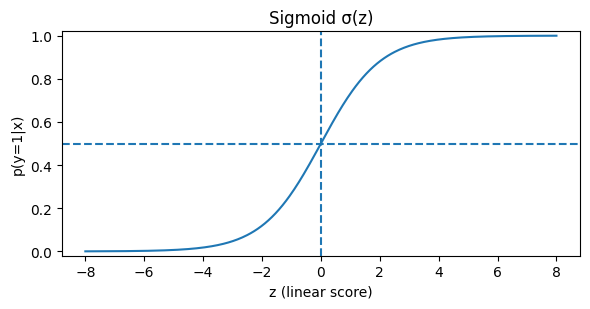

z= 0 -> σ(z)=0.500
z= 2 -> σ(z)=0.881
z=-2 -> σ(z)=0.119


In [28]:
z = np.linspace(-8, 8, 400)
p = sigmoid(z)

plt.figure(figsize=(6, 3.2))
plt.plot(z, p)
plt.axvline(0, linestyle="--")
plt.axhline(0.5, linestyle="--")
plt.title("Sigmoid σ(z)")
plt.xlabel("z (linear score)")
plt.ylabel("p(y=1|x)")
plt.ylim(-0.02, 1.02)
plt.tight_layout()
plt.show()

for val in [0, 2, -2]:
    print(f"z={val:>2} -> σ(z)={sigmoid(val):.3f}")


## 2) A clean 2D dataset


### 1. Data Generation

We create a synthetic **binary classification** dataset.
* **2 Features:** Allows us to plot it easily in 2D.
* **Noise:** We added `flip_y=0.05` (5% labels are flipped) to simulate real-world imperfections.

In [94]:
# A slightly noisy but separable dataset
RANDOM_STATE = 100; class_sep = 0.8  # Harder example
RANDOM_STATE = 7; class_sep = 1.3    # Easier example


X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=1,
    n_clusters_per_class=1,
    class_sep=class_sep,
    flip_y=0.1,
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f"Data created. Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Data created. Training shape: (700, 2), Test shape: (300, 2)


### 2. Visualizing the Problem

Before modeling, always look at your data.
* **Blue Circles:** Class 0
* **Red Triangles:** Class 1

Notice the overlap in the middle. A simple straight line (Linear Boundary) will likely make some mistakes here.

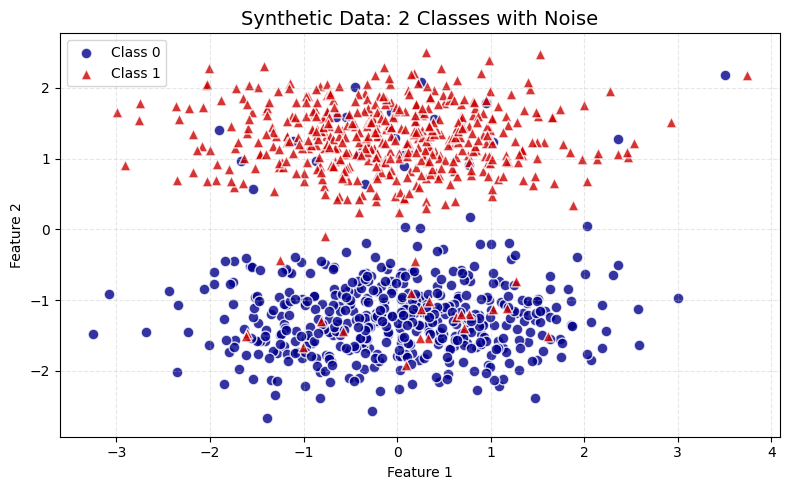

In [95]:
plt.figure(figsize=(8, 5))

# Plot Class 0
plt.scatter(X[y==0, 0], X[y==0, 1], c='#00008B', marker='o', 
            edgecolors='white', s=60, label='Class 0', alpha=0.8)

# Plot Class 1
plt.scatter(X[y==1, 0], X[y==1, 1], c='#CC0000', marker='^', 
            edgecolors='white', s=60, label='Class 1', alpha=0.8)

plt.title("Synthetic Data: 2 Classes with Noise", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Model Training & Performance

We train a standard **Logistic Regression** and evaluate it on the test set (data the model has never seen).

**Key Metrics:**
* **Accuracy:** % Correct guesses.
* **Log Loss:** How "confident" the model was in the correct answer (Lower is better).
* **F1 Score:** Harmonic mean of Precision/Recall (Good for balance).

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Train
model = LogisticRegression(C=1.0, solver="lbfgs")
model.fit(X_train, y_train)

# Predict
proba = model.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

# Evaluate
metrics = {
    "Accuracy":  accuracy_score(y_test, pred),
    "Precision": precision_score(y_test, pred, zero_division=0),
    "Recall":    recall_score(y_test, pred, zero_division=0),
    "F1":        f1_score(y_test, pred, zero_division=0),
    "ROC AUC":   roc_auc_score(y_test, proba),
    "Log loss":  log_loss(y_test, proba),
}

print(f"{'Metric':<15} Score")
print("-" * 25)
for k, v in metrics.items():
    print(f"{k:<15} {v:.3f}")

Metric          Score
-------------------------
Accuracy        0.947
Precision       0.941
Recall          0.953
F1              0.947
ROC AUC         0.946
Log loss        0.244


### Probability field + decision boundary (threshold $ \tau=0.5 $)

Because the sigmoid is monotonic, the **boundary** for $\tau=0.5$ is:
$$
\sigma(z)=0.5 \iff z=0 \iff \beta_0+\beta^\top x = 0
$$


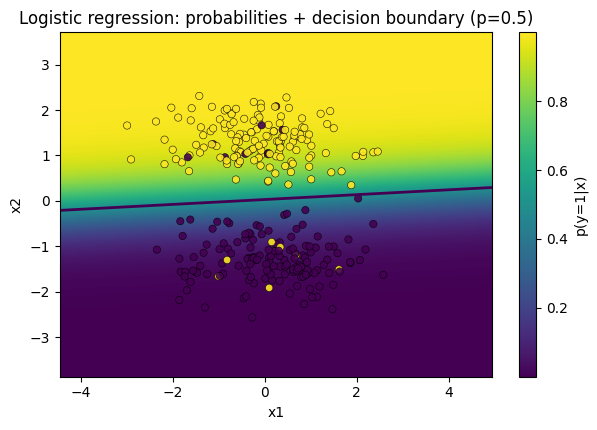

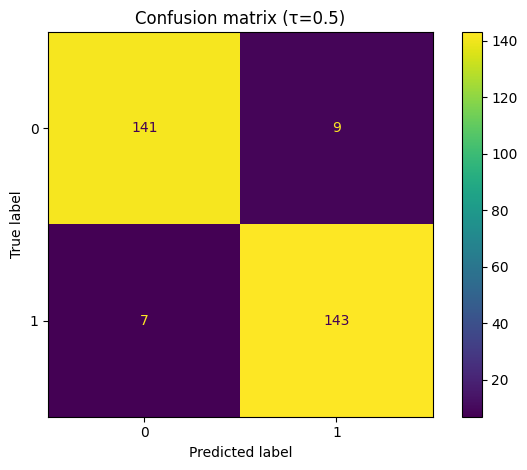

In [97]:
# Grid for probability field
pad = 1.2
x1_min, x1_max = X[:, 0].min() - pad, X[:, 0].max() + pad
x2_min, x2_max = X[:, 1].min() - pad, X[:, 1].max() + pad

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 220),
    np.linspace(x2_min, x2_max, 220)
)
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_p = model.predict_proba(grid)[:, 1].reshape(xx1.shape)

plt.figure(figsize=(6.2, 4.4))
plt.imshow(
    grid_p,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin="lower",
    aspect="auto"
)
plt.colorbar(label="p(y=1|x)")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=28, edgecolor="k", linewidth=0.4, alpha=0.9)
plt.contour(xx1, xx2, grid_p, levels=[0.5], linewidths=2)
plt.title("Logistic regression: probabilities + decision boundary (p=0.5)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
plt.title("Confusion matrix (τ=0.5)")
plt.tight_layout()
plt.show()


# 4. Thresholds and Metrics: The Trade-off

By default, we classify a sample as **Positive (1)** if $P(y=1|x) \ge 0.5$.
But is **0.5** always the best threshold ($\tau$)?

### Metrics Refresher (The Cheat Sheet)

| Metric | Formula | Intuition (The question it answers) |
| :--- | :--- | :--- |
| **Accuracy** | $\frac{TP+TN}{Total}$ | **"General Success"**<br>How often is the model correct overall? <br>*(Warning: Can be misleading if classes are imbalanced).* |
| **Precision** | $\frac{TP}{TP + FP}$ | **"Quality"**<br>Of all the ones I *claimed* were positive, how many were actually positive? |
| **Recall** | $\frac{TP}{TP + FN}$ | **"Quantity"**<br>Of all the *actual* positives existing in the world, how many did I manage to find? |
| **F1 Score** | $2 \cdot \frac{Prec \cdot Rec}{Prec + Rec}$ | **"Balance"**<br>The harmonic mean. Penalizes the model if *either* Precision or Recall is low. |

**The Trade-off:**
* **Raise $\tau$ (e.g., 0.8):** You become very selective. **Precision $\uparrow$**, but you miss many cases (**Recall $\downarrow$**).
* **Lower $\tau$ (e.g., 0.2):** You catch everyone. **Recall $\uparrow$**, but you get many false alarms (**Precision $\downarrow$**).

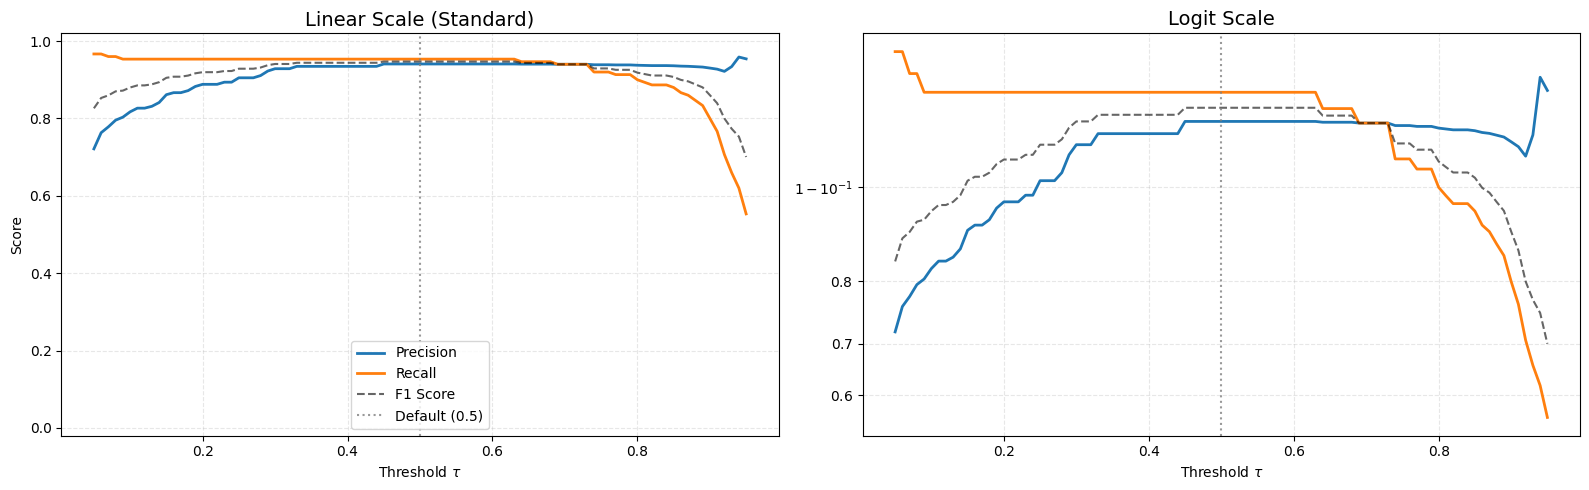

Threshold  Accuracy   Precision  Recall     F1 Score  
-------------------------------------------------------
τ=0.2       0.917      0.888      0.953      0.920     
τ=0.5       0.947      0.941      0.953      0.947     
τ=0.8       0.920      0.938      0.900      0.918     


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 1. Calculate metrics for all thresholds
taus = np.linspace(0.05, 0.95, 91)
prec_curve, rec_curve, f1_curve = [], [], []

for tau in taus:
    pred_tau = (proba >= tau).astype(int)
    prec_curve.append(precision_score(y_test, pred_tau, zero_division=0))
    rec_curve.append(recall_score(y_test, pred_tau, zero_division=0))
    f1_curve.append(f1_score(y_test, pred_tau, zero_division=0))

# 2. Plotting (Side-by-Side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# --- PLOT 1: LINEAR SCALE (Standard) ---
ax1.plot(taus, prec_curve, label="Precision", linewidth=2)
ax1.plot(taus, rec_curve, label="Recall", linewidth=2)
ax1.plot(taus, f1_curve, label="F1 Score", linestyle='--', color='black', alpha=0.6)
ax1.axvline(0.5, color='gray', linestyle=':', alpha=0.8, label='Default (0.5)')
ax1.set_title("Linear Scale (Standard)", fontsize=14)
ax1.set_xlabel("Threshold $\\tau$")
ax1.set_ylabel("Score")
ax1.set_ylim(-0.02, 1.02)
ax1.legend(loc='lower center')
ax1.grid(True, linestyle='--', alpha=0.3)

# --- PLOT 2: LOGIT SCALE (Zoom in on 0 and 1) ---
# "Logit" stretches the space near 0 and 1 so you can see the nines (0.9 vs 0.99)
ax2.plot(taus, prec_curve, label="Precision", linewidth=2)
ax2.plot(taus, rec_curve, label="Recall", linewidth=2)
ax2.plot(taus, f1_curve, label="F1 Score", linestyle='--', color='black', alpha=0.6)
ax2.axvline(0.5, color='gray', linestyle=':', alpha=0.8)


ax2.set_yscale('logit')  # <--- THE MAGIC LINE
ax2.set_title("Logit Scale", fontsize=14)
ax2.set_xlabel("Threshold $\\tau$")
ax2.grid(True, which='both', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Print numeric comparison
print(f"{'Threshold':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 55)
for tau in [0.2, 0.5, 0.8]:
    pred_tau = (proba >= tau).astype(int)
    acc = accuracy_score(y_test, pred_tau)
    prec = precision_score(y_test, pred_tau, zero_division=0)
    rec = recall_score(y_test, pred_tau, zero_division=0)
    f1 = f1_score(y_test, pred_tau, zero_division=0)
    
    print(f"τ={tau:<9.1f} {acc:<10.3f} {prec:<10.3f} {rec:<10.3f} {f1:<10.3f}") 

# Visualizing L2 Regularization (Ridge)

In this visualization, we explicitly use **L2 Regularization**. We have added a text box in each plot showing the **Weight Magnitude** ($||w||$).

### The Math: Why look at $||w||$?
The "wiggliness" of the line is determined by the size of the weights (coefficients) in the polynomial equation.

* **$\|w\| \approx 0$:** The equation has almost no power. The line is flat.
* **$\|w\|$ is Moderate:** The equation has enough power to curve, but not enough to snap back and forth violently.
* **$\|w\|$ is Huge:** To create the sharp islands seen in overfitting, the model must use massive weights (e.g., $1000 \cdot x^{10}$).

### The Cost Function (What the computer minimizes)
To find the best line, the computer tries to minimize the **Total Cost**. Notice how $C$ affects the penalty on the weights $w$:

$$J(w) = \underbrace{\text{Log Loss}}_{\text{Error on Training Data}} + \underbrace{\frac{1}{C} \sum w_j^2}_{\text{Penalty for Complexity}}$$

* **Log Loss:** This part tries to make the model fit every single data point perfectly.
* **The Penalty ($\sum w^2$):** This part tries to keep the equation simple (weights near zero).
* **The Balance ($1/C$):**
    * If **$C$ is Small** (e.g., 0.01), then $\frac{1}{C}$ is **Huge**. The penalty becomes dominant. The model prioritizes simplicity (small $w$).
    * If **$C$ is Large** (e.g., 10,000), then $\frac{1}{C}$ is **Tiny**. The penalty is ignored. The model prioritizes fitting every data point (Overfitting).



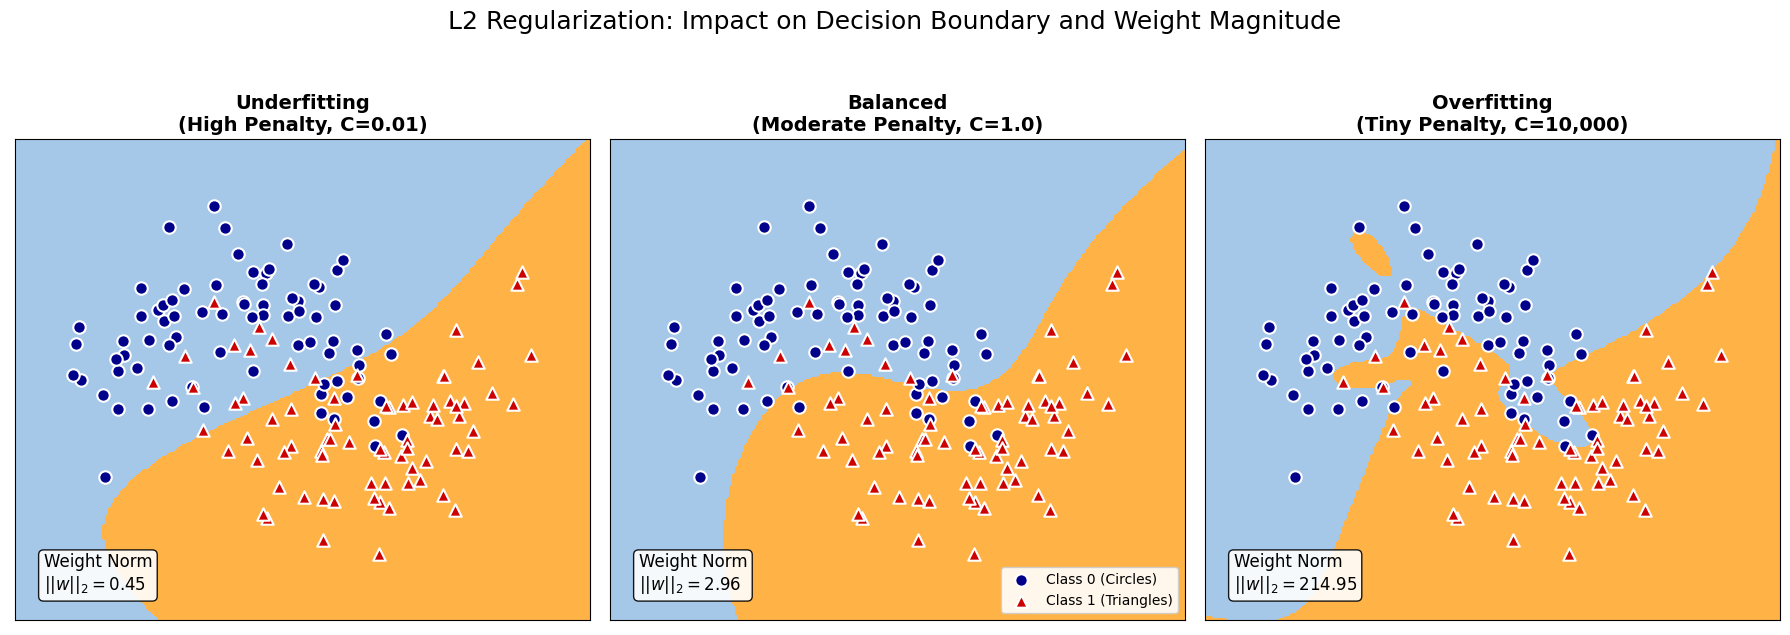

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# 1. Generate Data
X, y = make_moons(n_samples=150, noise=0.3, random_state=42)

# --- PROJECTOR-SAFE COLORS & SHAPES ---
cmap_background = ListedColormap(['#A6C8E8', '#FFB347']) # Solid Light Blue, Solid Bright Orange
color_class0 = '#00008B' # Dark Blue
color_class1 = '#CC0000' # Dark Red/Orange

def plot_decision_boundary(ax, C_value, title, show_legend=False):
    # Pipeline setup
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=10, include_bias=False)),
        ("scaler", StandardScaler()),
        # Using L2 (Ridge) Regularization
        ("logit", LogisticRegression(penalty='l2', C=C_value, solver="lbfgs", max_iter=5000))
    ])
    
    model.fit(X, y)

    # Grid for background
    x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, 200),
                           np.linspace(x1_min, x1_max, 200))
    
    Z = model.predict(np.c_[xx0.ravel(), xx1.ravel()])
    Z = Z.reshape(xx0.shape)

    # Plot background
    ax.contourf(xx0, xx1, Z, cmap=cmap_background, alpha=1.0)
    
    # --- PLOTTING POINTS ---
    X_c0 = X[y == 0]
    X_c1 = X[y == 1]

    ax.scatter(X_c0[:, 0], X_c0[:, 1], color=color_class0, marker='o',
               edgecolors='white', linewidth=1.5, s=80, label='Class 0 (Circles)')
    
    ax.scatter(X_c1[:, 0], X_c1[:, 1], color=color_class1, marker='^',
               edgecolors='white', linewidth=1.5, s=80, label='Class 1 (Triangles)')
    
    # --- CALCULATE AND DISPLAY WEIGHT NORM ---
    # We access the logistic regression step to get the coefficients (weights)
    weights = model.named_steps['logit'].coef_
    # Calculate L2 Norm (Euclidean length of the weight vector)
    w_norm = np.linalg.norm(weights)
    
    # Add text box with the norm value (using w)
    text_str = f"Weight Norm\n$||w||_2 = {w_norm:.2f}$"
    ax.text(0.05, 0.05, text_str, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks([]) 
    ax.set_yticks([])

    if show_legend:
        ax.legend(loc='lower right', framealpha=0.9, facecolor='white')

# Setup figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot the three cases
plot_decision_boundary(ax1, C_value=0.01, title="Underfitting\n(High Penalty, C=0.01)")
plot_decision_boundary(ax2, C_value=1.0, title="Balanced\n(Moderate Penalty, C=1.0)", show_legend=True)
plot_decision_boundary(ax3, C_value=10000, title="Overfitting\n(Tiny Penalty, C=10,000)")

plt.suptitle("L2 Regularization: Impact on Decision Boundary and Weight Magnitude", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

### What to look for in the plots:

1.  **Left (High Penalty):** Look at the **Norm**. It will be very small. The model is "poor" and cannot afford complex shapes.
2.  **Middle (Moderate Penalty):** The Norm is reasonable. The model "pays" for the general shape but refuses to pay for the noise.
3.  **Right (Tiny Penalty):** Look at the **Norm**. It creates an explosion in weight size. The model is "rich" and spends "budget" on memorizing every single point.

## Finding the "Sweet Spot" (Model Selection)

We saw that:
* **Low $C$:** High Error (Underfitting)
* **High $C$:** Low Training Error, but High Test Error (Overfitting)

To find the best $C$, we plot the **Log Loss** for both Training and Test sets across different values.

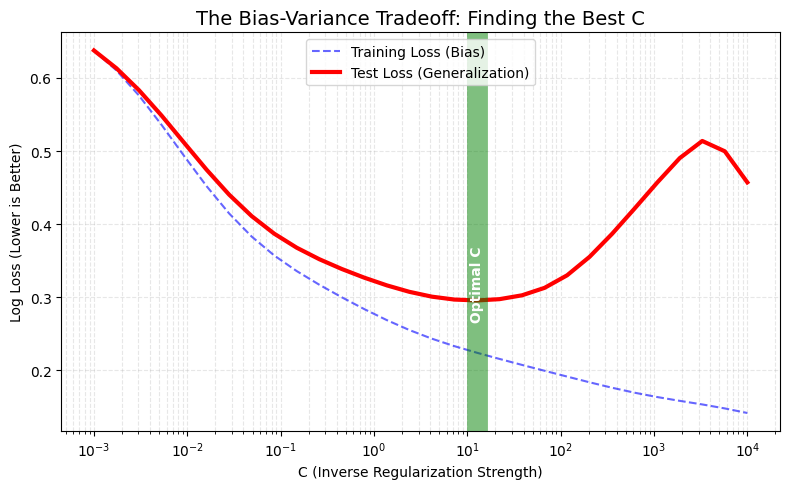

In [36]:
# --- FINDING OPTIMAL C (Grid Search Visualization) ---
from sklearn.metrics import log_loss

# 1. Setup range of C values (logarithmic scale)
# We go from 0.001 to 10000
Cs = np.logspace(-3, 4, 30)

train_losses = []
test_losses = []
weight_norms = []

# 2. Train a model for each C using the SAME Moons data
# Note: We must split the data first to calculate Test Loss
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

for C in Cs:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=10, include_bias=False)),
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(C=C, solver="lbfgs", max_iter=5000))
    ])
    model.fit(X_tr, y_tr)
    
    # Calculate Log Loss
    train_losses.append(log_loss(y_tr, model.predict_proba(X_tr)))
    test_losses.append(log_loss(y_te, model.predict_proba(X_te)))
    
    # Store weight magnitude
    weight_norms.append(np.linalg.norm(model.named_steps['logit'].coef_))

# 3. Plotting
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot Losses (Left Axis)
ax1.plot(Cs, train_losses, 'b--', label='Training Loss (Bias)', alpha=0.6)
ax1.plot(Cs, test_losses, 'r-', linewidth=3, label='Test Loss (Generalization)')
ax1.set_xscale('log')
ax1.set_xlabel('C (Inverse Regularization Strength)')
ax1.set_ylabel('Log Loss (Lower is Better)')
ax1.legend(loc='upper center')
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

# Add "Sweet Spot" marker
best_idx = np.argmin(test_losses)
best_C = Cs[best_idx]
ax1.axvline(best_C, color='green', alpha=0.5, linewidth=15)
ax1.text(best_C, np.max(test_losses)*0.5, " Optimal C ", rotation=90, va='center', ha='center', color='white', fontweight='bold')

plt.title("The Bias-Variance Tradeoff: Finding the Best C", fontsize=14)
plt.tight_layout()
plt.show()